## Run of homozygosity analyses

Addresses [issue 10](https://github.com/malariagen/agam-kilifi-report-2017/issues/10)

In [1]:
%run setup.ipynb

In [2]:
# plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('paper')
plt.rcParams['figure.dpi'] = 120
%config InlineBackend.figure_formats = {'retina', 'png'}

In [3]:
import popgen

In [4]:
analysis = popgen.analysis.PopulationAnalysis('../data/analysis')
analysis

<PopulationAnalysis at '../data/analysis'>

In [5]:
roh_calls = analysis.open_callset("main_roh")

In [6]:
roh_calls_cross = analysis.open_callset("cross_roh")

In [7]:
populations = ["junju", "mbogolo"]

In [8]:
x_tab_fn = os.path.join("..", "ngs.sanger.ac.uk/production", 
                        "ag1000g/phase1/AR3.1/samples", 
                        "cross.samples.meta.txt")

tbl_cross = pandas.read_table(x_tab_fn, index_col="ox_code").query("role == 'parent'")

In [9]:
analysis.get_population_label("junju")

'Kilifi-Junju (n=13)'

In [10]:
population_ix = {p:analysis.get_population_samples(p) 
                 for p in populations}

In [11]:
tbl_samples = analysis.load_sample_table()

In [12]:
chromosomes = chromosomes[:5]
chromosomes

('2R', '2L', '3R', '3L', 'X')

## Create ROH summary data

In [13]:
colnames = ["nROH", "sumROH"]

In [14]:
genome_size = np.sum(
    [len(analysis.genome_assembly[c]) for c in chromosomes])

In [15]:
# Create table for ag1k p1
mi = pandas.MultiIndex.from_product(
    [tbl_samples.index, chromosomes])

roh_summary = pandas.DataFrame(index=mi, columns=colnames)

In [16]:
# create table for crosses
mi = pandas.MultiIndex.from_product(
    [tbl_cross.index, chromosomes])

roh_summary_cross = pandas.DataFrame(index=mi, columns=colnames)

In [17]:
def summary_roh(y, callfh, min_size=10000):
    
    sample, chrom = y.name
    x = callfh[chrom][sample][:]
    
    if x.shape[0] == 0:
        return 0, 0.0
    
    xlen = np.diff(x, 1)
    
    try:
        meet_t = (xlen >= min_size).reshape((-1,))
        x = x.compress(meet_t, 0)
    except ValueError:
        print(meet_t)
        print(x)
    
    ncalls = x.shape[0]
    rohsum = np.diff(x, 1).sum()
    return ncalls, rohsum

In [18]:
roh_summary = roh_summary.apply(summary_roh, 1, 
                                callfh=roh_calls)

In [19]:
list(roh_calls_cross["2L"].keys())

['AD0231-C',
 'AD0232-C',
 'AD0254-C',
 'AD0255-C',
 'AD0305-C',
 'AD0306-C',
 'AD0347-C',
 'AD0348-C']

In [20]:
roh_summary_cross = roh_summary_cross.apply(summary_roh, 1,
                                            callfh=roh_calls_cross)

In [22]:
roh_summary = pandas.concat([roh_summary, roh_summary_cross])

In [23]:
roh_combined = roh_summary.groupby(level=0).aggregate(np.sum)

In [24]:
roh_combined["fROH"] = roh_combined.sumROH / genome_size

In [25]:
roh_combined.head()

,nROH,sumROH,fROH
AB0085-C,113,16352346,0.070953
AB0087-C,102,10475384,0.045453
AB0088-C,158,17991332,0.078065
AB0089-C,91,12861014,0.055804
AB0090-C,161,11035107,0.047882


In [30]:
tbl_cross["population"] = "colony"
tbl_cross["region"] = tbl_cross["colony_id"] 

In [33]:
tbl_samples = pandas.concat([tbl_samples, tbl_cross])

In [34]:
mm = pandas.merge(roh_combined, tbl_samples, 
                  left_index=True, right_index=True)

## Make plots

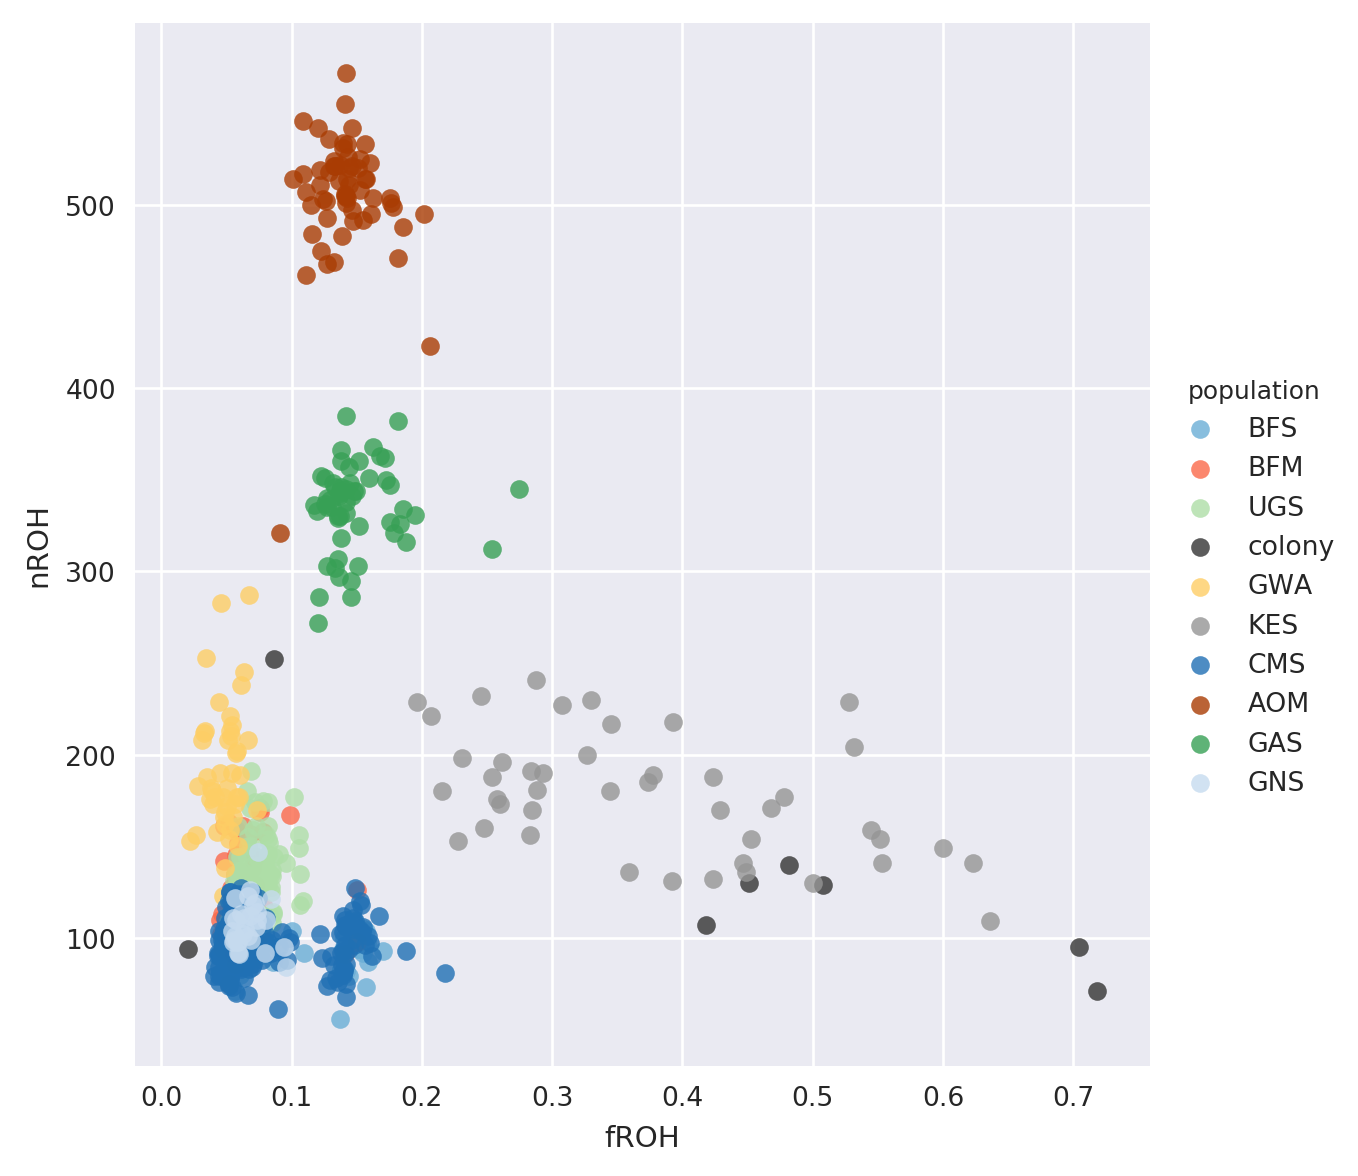

In [36]:
sns.lmplot("fROH", "nROH", data=mm, hue="population", 
           fit_reg=False, palette=phase1_ar3.pop_colors)

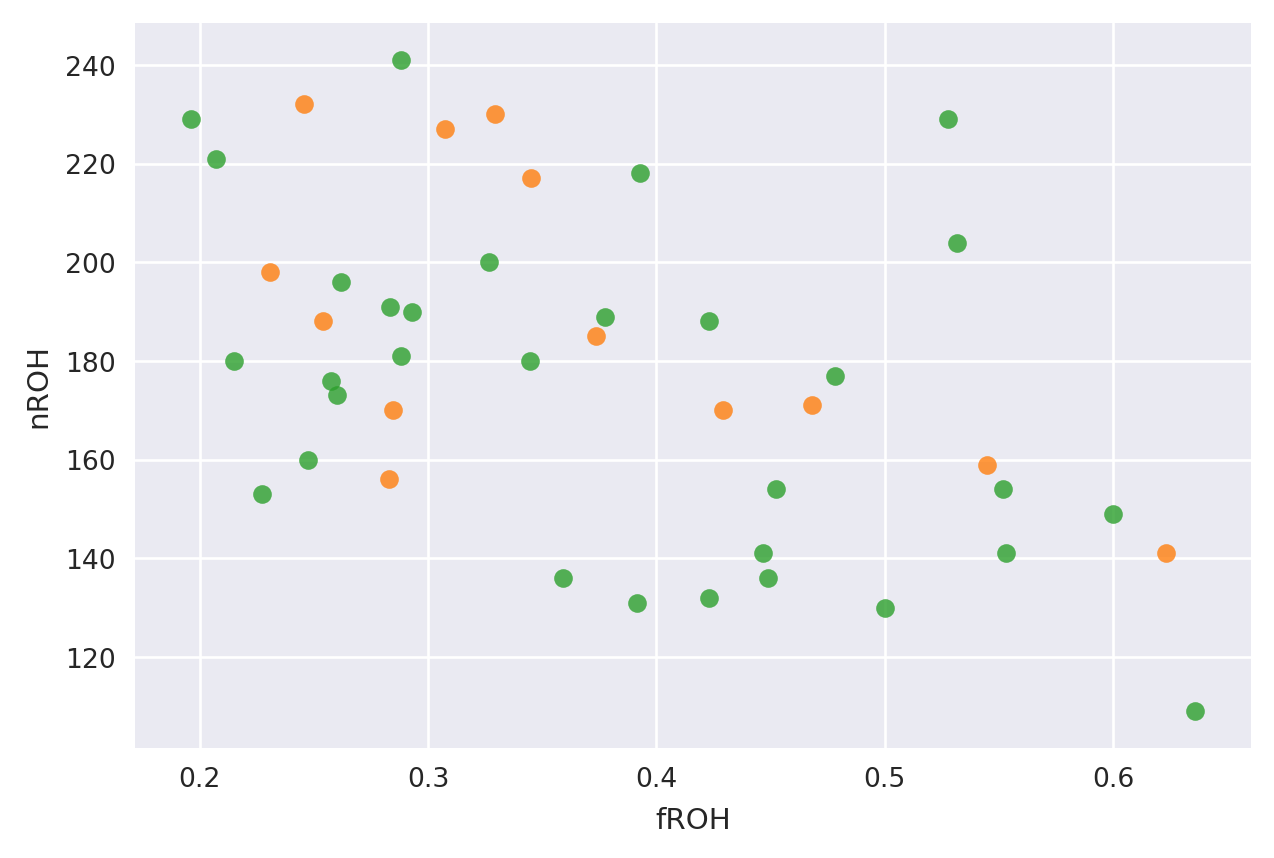

In [46]:
fig, ax = plt.subplots()

for p in populations:
    cfg = analysis.config.get_population(p)
    sns.regplot("fROH", "nROH", 
               data=mm.query(cfg["query"]), 
               color=cfg["color"], fit_reg=False, ax=ax)